In [1]:
import torch
import torch.functional as F
import matplotlib.pyplot as plt
import tqdm
from typing import Callable

%matplotlib ipympl

In [26]:
# Define the target function to evaluate each 2D point
def f(x, y):  # x: (..., 2)
    xt = torch.stack((x.flatten(), y.flatten()), dim=1)
    return torch.abs(-torch.norm(xt - torch.tensor([1.0, 1.0], device=xt.device), dim=-1))

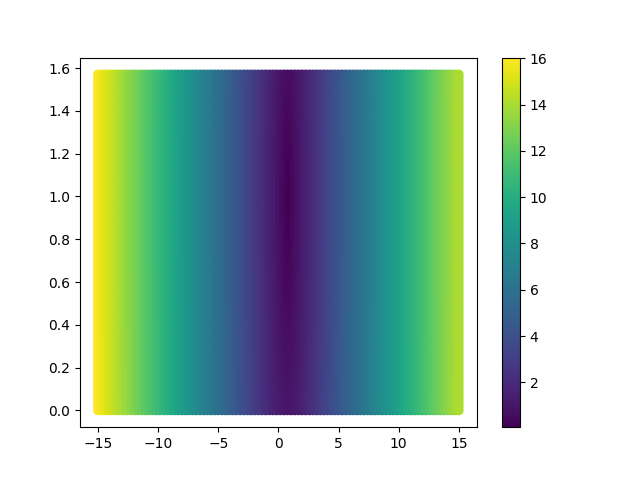

In [88]:
x = torch.linspace(-15, 15, 100)
t = torch.linspace(0, torch.pi / 2, 100)

X, T = torch.meshgrid(x, t)
# X = X.flatten()
# T = T.flatten()
# XT = torch.stack([X.flatten(), T.flatten()], dim=-1)
y = f(X, T)

plt.gcf().clear()
plt.scatter(X, T, c=y)
plt.colorbar()
plt.show()

In [85]:
from typing import Callable


class RADPointGenerator:
    def __init__(
        self,
        func: Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
        x_bounds,
        y_bounds,
        max_points=1000,
        min_explore_points=100,
        noise_factor=0.1,
        device="cpu",
    ):
        self.func = func
        self.x_bounds = x_bounds
        self.y_bounds = y_bounds
        self.device = device
        self.max_points = max_points
        self.min_explore_points_n = min_explore_points
        self.n_points_to_generate = max_points - min_explore_points
        self.x_noise = (x_bounds[1] - x_bounds[0]) * noise_factor
        self.y_noise = (y_bounds[1] - y_bounds[0]) * noise_factor
        self.points_x, self.points_y = self.sample_uniform(self.max_points)

    def sample_uniform(self, n):
        x_min, x_max = self.x_bounds
        y_min, y_max = self.y_bounds
        xs = torch.empty(n, device=self.device).uniform_(x_min, x_max)
        ys = torch.empty(n, device=self.device).uniform_(y_min, y_max)
        return xs, ys

    def generate(self):
        x, y = self.points_x, self.points_y
        weights = self.func(x, y).abs()
        chosen_indexes = torch.multinomial(
            weights, self.n_points_to_generate, replacement=True
        )
        x_new: torch.Tensor = torch.clamp(
            x[chosen_indexes]
            + torch.empty(self.n_points_to_generate, device=self.device).uniform_(
                -self.x_noise, self.x_noise
            ),
            *self.x_bounds,
        )
        y_new: torch.Tensor = torch.clamp(
            y[chosen_indexes]
            + torch.empty(self.n_points_to_generate, device=self.device).uniform_(
                -self.y_noise, self.y_noise
            ),
            *self.y_bounds,
        )

        x_explore, y_explore = self.sample_uniform(self.min_explore_points_n)

        x_new = torch.cat((x_new, x_explore))
        y_new = torch.cat((y_new, y_explore))

        self.points_x = x_new
        self.points_y = y_new
        return x_new, y_new


In [86]:
generator = RADPointGenerator(f, (-15, 15), (0, torch.pi / 2))

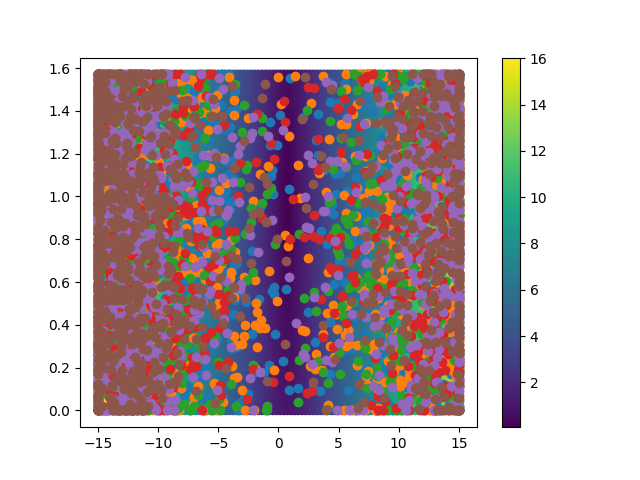

(None,
 tensor([-12.1399, -13.8855, -15.0000,   8.3528, -13.3602, -15.0000, -13.3961,
         -15.0000, -15.0000, -15.0000, -13.9461,  15.0000, -14.1043, -10.3749,
          -6.3406, -13.7995, -15.0000,  -9.8706,  -8.4256, -15.0000,  13.2572,
         -10.5928, -11.3791, -15.0000, -11.6037, -12.2066, -14.9434,  12.0623,
         -14.9465,  15.0000, -10.1574, -15.0000, -13.9819, -13.2942, -15.0000,
         -13.0178,  -9.7328, -15.0000, -13.0053, -10.5589, -11.9321, -10.4847,
         -14.3748,  15.0000, -13.3766,  14.6801,  -8.4562,  -8.2735,  -6.8250,
          -9.7225, -13.9662,  10.4239, -13.2968,  15.0000, -10.5371, -11.2999,
         -12.5284, -14.3538,  13.6536, -15.0000, -10.3307, -15.0000, -11.1822,
         -15.0000, -15.0000, -14.8590,  -8.7067,  -8.6220,  11.1279,   6.8319,
         -11.4133,  10.4300,   2.8868, -13.0363,  -9.2104, -14.5138, -14.1980,
           7.6068, -11.8536, -15.0000, -15.0000, -11.7207,  12.6211, -15.0000,
         -12.3784, -15.0000, -15.0000,  14.55

In [94]:
x, y = generator.generate()
plt.scatter(x, y)
plt.show(), x, y

In [78]:
points = generator.generate()
points.shape

tensor([2.7301e+01, 2.1065e+01, 2.5961e+01, 2.3694e+01, 2.3458e+01, 2.9040e+01,
        2.6447e+01, 2.3869e+01, 2.3419e+01, 2.3892e+01, 2.3243e+01, 2.0482e+01,
        2.3048e+01, 2.6523e+01, 2.8847e+01, 2.1225e+01, 2.4369e+01, 2.6182e+01,
        2.4986e+01, 2.8038e+01, 2.4230e+01, 2.6399e+01, 2.7328e+01, 2.7589e+01,
        2.7147e+01, 2.2159e+01, 2.4520e+01, 2.3259e+01, 2.4176e+01, 2.8108e+01,
        2.4025e+01, 2.4814e+01, 2.1370e+01, 2.6893e+01, 2.7874e+01, 2.2985e+01,
        2.5031e+01, 2.5718e+01, 2.1474e+01, 2.5026e+01, 2.3949e+01, 2.1298e+01,
        2.4485e+01, 2.9240e+01, 2.4961e+01, 2.7084e+01, 2.5663e+01, 2.5695e+01,
        2.6206e+01, 2.5279e+01, 2.7175e+01, 2.3575e+01, 2.0551e+01, 2.6060e+01,
        2.2995e+01, 2.6410e+01, 2.6341e+01, 2.5713e+01, 2.6123e+01, 2.8983e+01,
        2.2783e+01, 2.4603e+01, 2.6834e+01, 2.8336e+01, 2.9255e+01, 2.0903e+01,
        2.7395e+01, 2.7953e+01, 2.6316e+01, 2.6930e+01, 2.6347e+01, 2.2065e+01,
        2.8278e+01, 2.8215e+01, 2.6551e+

AttributeError: 'tuple' object has no attribute 'shape'

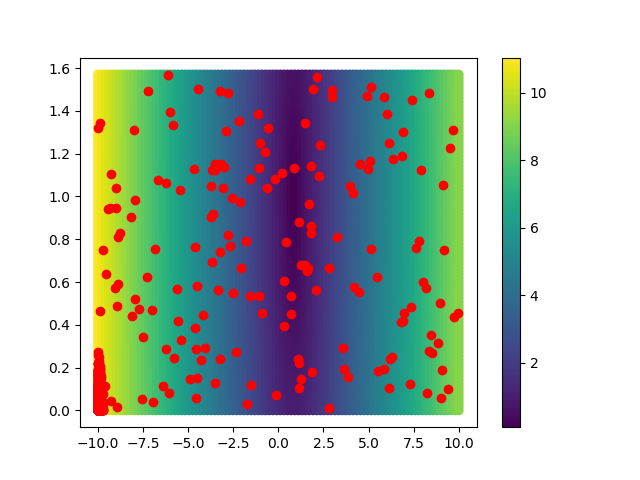

In [134]:
plt.gca().clear()
plt.scatter(X, T, c=y)
plt.scatter(points[:, 0], points[:, 1], c="red")
plt.show()